# Source Overlap

This notebook demonstrates 3 methods of estimating overlap between two sources given shape measurements.


**1. Object Purity:**

> Represent each object with a 2D elliptical Gaussian profile. Calculate (analytically) the "purity" between the objects following eq (9.2) of [Sanchez+2021](https://arxiv.org/abs/2103.02078).
    
**2. Ellipse Overlapping (HC):**

> Represent each object with an ellipse of $a, b,$ and $\theta$ estimated at the FWHM contour of its 2D Gaussian profile. Calculate (analytically) the overlap area between the two ellipses following [Hughes & Chraibi 2011](https://arxiv.org/abs/1106.3787), hereafter **HC2011**.

**3. Ellipse Overlapping (MC):**
> Same as 2, but estimate the overlap area with Monte Carlo sampling.

last verified to run: 07 Mar. 2023 on **desc-python-dev**

In [1]:
import numpy as np
import matplotlib, timeit
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

## 1. Object Purity
Define a 2D elliptical Gaussian (centered at $\boldsymbol{\mu}$) as:

\begin{equation}
G\left(\textbf{r}|\boldsymbol{\mu}, \Sigma\right) 
    = \frac{F}{2\pi\sqrt{|\Sigma|}}\exp\left(-\frac{1}{2}(\textbf{r} 
    - \boldsymbol{\mu})\cdot\Sigma^{-1}\cdot (\textbf{r} - \boldsymbol{\mu}) \right),
\end{equation}

\begin{equation}
    \Sigma = 
    \begin{bmatrix} 
        I_{xx} &  I_{xy}\\ I_{xy} & I_{yy} 
    \end{bmatrix}; 
    \qquad
    \Sigma^{-1} = \frac{1}{I_{xx}I_{yy} -  I_{xy}I_{xy}}
    \begin{bmatrix} 
        I_{yy} &  -I_{xy}\\ -I_{xy} & I_{xx} \end{bmatrix},
    \end{equation}  

where $I_{xx}$, $I_{yy}$ and $I_{xy}$ are the second moments of the sources. 

Some calculations lead to:
\begin{equation}
\begin{aligned}
    I_{xx} &= \frac{1}{2\ln{2}} \left( a^2 \cos^2 \theta + b^2 \sin^2 \theta \right), \\
    I_{xy} &= \frac{1}{2\ln{2}} \left( a^2 - b^2 \right) \sin \theta \cos \theta,  \\
    I_{yy} &= \frac{1}{2\ln{2}} \left( a^2 \sin^2 \theta + b^2 \cos^2 \theta  \right), \\
    I_{xx}I_{yy} - I^2_{xy} & = \frac{a^2 b^2}{4(\ln{2})^2}, \\
    \Sigma & = \frac{1}{2 \ln{2}}
    \begin{bmatrix} 
        a^2 \cos^2 \theta + b^2 \sin^2 \theta &  (a^2 - b^2) \sin \theta \cos \theta \\
        (a^2 - b^2) \sin \theta \cos \theta & a^2 \sin^2 \theta + b^2 \cos^2 \theta 
    \end{bmatrix}, \\
    \Sigma^{-1} & = \frac{2\ln{2}}{a^2 b^2}
    \begin{bmatrix} 
        a^2 \sin^2 \theta + b^2 \cos^2 \theta &  (b^2 - a^2) \sin \theta \cos \theta \\
        (b^2 - a^2) \sin \theta \cos \theta & a^2 \cos^2 \theta + b^2 \sin^2 \theta 
    \end{bmatrix}.
\end{aligned}
\end{equation}

where $a, b, \theta$ characterize the ellipse of the FWHM contour. 

The purity of a pair of objects is defined individually. For object 1, it is (eq [9.2] of [Sanchez+2021](https://arxiv.org/abs/2103.02078)):

\begin{equation}
P_1 = \frac{\int G_1^2(\textbf{r}) dxdy}
           {\int \left( G_1^2(\textbf{r}) + G_1(\textbf{r}) \cdot G_2(\textbf{r}) \right) dxdy},
\end{equation}
and for object 2:
\begin{equation}
P_2 = \frac{\int G_2^2(\textbf{r}) dxdy}
           {\int \left( G_2^2(\textbf{r}) + G_1(\textbf{r}) \cdot G_2(\textbf{r}) \right) dxdy}.
\end{equation}

Given two Gaussian profiles, one centered at $\mathbf{0}$ and one at $\boldsymbol{\mu}$, a multiplied integral is calculated in eq (3) of [J. Duda 2018](https://arxiv.org/abs/1811.04751):

\begin{equation}
\begin{aligned}
\int G_1\left( \textbf{r}|\boldsymbol{0}, \Sigma_1 \right) \cdot
     G_2\left( \textbf{r}|\boldsymbol{\mu}, \Sigma_2 \right) dxdy
& = \frac{F_1 F_2}{4\pi^2 \sqrt{|\Sigma_1|\cdot |\Sigma_2|}}
\int \exp \left( -\frac{1}{2}\textbf{r}\cdot\Sigma_1^{-1}\cdot\textbf{r}
                 -\frac{1}{2}(\textbf{r}-\boldsymbol{\mu})\cdot\Sigma_2^{-1}\cdot(\textbf{r} 
                 - \boldsymbol{\mu}) \right) dxdy \\
& = \frac{F_1 F_2}{2\pi \sqrt{|\Sigma_1| \cdot |\Sigma_2| \cdot |\Sigma_1^{-1} + \Sigma_2^{-1}|}}
    \exp \left( 
        -\frac{1}{2} \boldsymbol{\mu} \cdot \Sigma_2^{-1} 
        \left(\Sigma_1^{-1} + \Sigma_2^{-1} \right) 
        \Sigma_1^{-1} \cdot \boldsymbol{\mu}
         \right).
\end{aligned}
\end{equation}

Therefore, the general formula is

\begin{equation}
\int G_1\left( \textbf{r}|\boldsymbol{\mu}_1, \Sigma_1 \right) \cdot
     G_2\left( \textbf{r}|\boldsymbol{\mu}_2, \Sigma_2 \right) dxdy
     = \frac{F_1 F_2}{2\pi \sqrt{|\Sigma_1| \cdot |\Sigma_2| \cdot |\Sigma_1^{-1} + \Sigma_2^{-1}|}}
    \exp \left( 
        -\frac{1}{2} (\boldsymbol{\mu}_2 - \boldsymbol{\mu}_1 )\cdot \Sigma_2^{-1} 
        \left(\Sigma_1^{-1} + \Sigma_2^{-1} \right) 
        \Sigma_1^{-1} \cdot (\boldsymbol{\mu}_2 - \boldsymbol{\mu}_1)
         \right).
\end{equation}


In [2]:
def ab2cov(p_ab):
    
    a, b, theta, x, y = p_ab
    
    sin = np.sin(np.radians(theta))
    cos = np.cos(np.radians(theta))

    C11 = (a*cos)**2 + (b*sin)**2
    C22 = (a*sin)**2 + (b*cos)**2
    C12 = (a**2 - b**2)*sin*cos
    C21 = C12

    cov = np.array( [[C11, C12], [C21, C22]]) / (2*np.log(2))
    
    ## the inverse matrix
    
    D11 = (a*sin)**2 + (b*cos)**2
    D22 = (a*cos)**2 + (b*sin)**2
    D12 = (b**2 - a**2)*sin*cos
    D21 = D12
    
    cov_inv = 2*np.log(2)* np.array( [[D11, D12], [D21, D22]]) / (a*b)**2
    
    return cov, cov_inv    

def gaussian_overlap(p1_ab, p2_ab, F1=1, F2=1):
    
    ## continuous version of eq (9.2) of https://arxiv.org/abs/2103.02078, but only for i=1, j=1 
    
    a1, b1, theta1, x1, y1 = p1_ab     
    a2, b2, theta2, x2, y2 = p2_ab
    
    mu = np.array([x2-x1, y2-y1])
    
    cov1, cov_inv1 = ab2cov(p1_ab)
    cov2, cov_inv2 = ab2cov(p2_ab)
    
    det1 = np.linalg.det(cov1)
    det2 = np.linalg.det(cov2)
    det_inv_sum = np.linalg.det( cov_inv1 + cov_inv2 )
    
    part1 = F1*F2 / (2*np.pi * np.sqrt( det1 * det2 * det_inv_sum ) )
    part2 = np.exp( - mu@cov_inv2@(cov_inv1+cov_inv2)@cov_inv1@mu / 2 )

    return part1 * part2

def gaussian_square_int(p_ab, F=1):
    
    ## calculate the integral of a sqaured gaussian profile
    ## equivalent to gaussian_overlap(p_ab, p_ab), but faster.
    a, b, theta, x, y = p_ab
    cov, cov_inv = ab2cov(p_ab)
    
    res = F / (4*np.pi*np.sqrt(np.linalg.det(cov)))
    
    return res


### Some Examples

In [3]:
def set_random_pair(center_on_ell1=False):
    
    if center_on_ell1:
        x1, y1 = 0, 0
        theta1 = 0
    else:
        x1, y1 = np.random.uniform(-2,2,2)  ## center of ellipse 1
        theta1 = np.random.uniform(0, 180)  ## in degrees
        
    a1, b1 = np.random.uniform(1,3,2)
    if b1 > a1:
        a1, b1 = b1, a1

    x2, y2 = np.random.uniform(-2,2,2)  ## center of ellipse 2
    a2, b2 = np.random.uniform(0.5,2,2)
    theta2 = np.random.uniform(0, 180)  ## in degrees
    if b2 > a2:
        a2, b2 = b2, a2

    p1_ab = [a1, b1, theta1, x1, y1]
    p2_ab = [a2, b2, theta2, x2, y2]

    return p1_ab, p2_ab

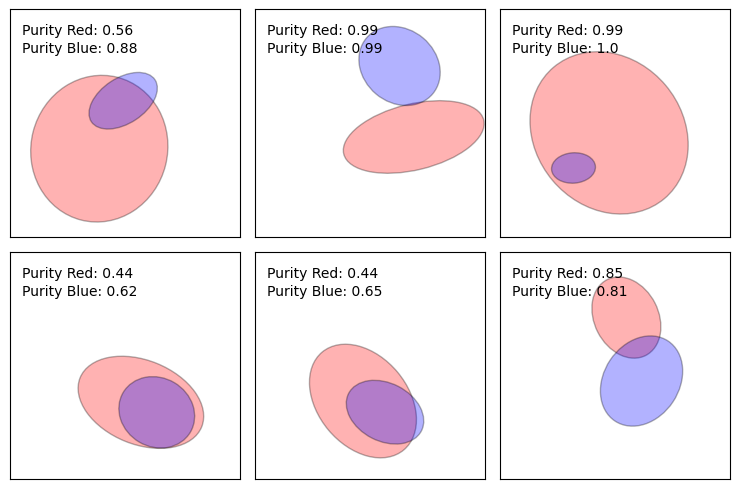

In [4]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(7.5,5))

for i, ax in enumerate(axes.ravel()):

    p1_ab, p2_ab = set_random_pair()
    
    cov1, cov_inv1 = ab2cov(p1_ab)
    cov2, cov_inv2 = ab2cov(p2_ab)
    
    a1, b1, theta1, x1, y1 = p1_ab
    a2, b2, theta2, x2, y2 = p2_ab
    
    int_11 = gaussian_square_int(p1_ab)
    int_22 = gaussian_square_int(p2_ab)
    int_12 = gaussian_overlap(p1_ab, p2_ab)
    int_21 = int_12    ## equal to gaussian_overlap(p2_ab, p1_ab)

    purity1 = int_11 / (int_11 + int_12)
    purity2 = int_22 / (int_22 + int_21)

    ax.text(x=-3.5, y=3.0, s=f'Purity Red: {np.around(purity1, decimals=2)}')
    ax.text(x=-3.5, y=2.4, s=f'Purity Blue: {np.around(purity2, decimals=2)}')

    ellipse1 = Ellipse((x1,y1), width=2*a1, height=2*b1, angle=theta1, facecolor='r', edgecolor='k', alpha=0.3, linewidth=1)
    ellipse2 = Ellipse((x2,y2), width=2*a2, height=2*b2, angle=theta2, facecolor='b', edgecolor='k', alpha=0.3, linewidth=1)
    ax.add_artist(ellipse1)
    ax.add_artist(ellipse2)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    ax.axis('equal')

plt.tight_layout()

In [5]:
def set_unrec_bl():
    
    x1, y1 = 0,0  ## center of ellipse 1
    a1, b1 = np.random.uniform(1,3,2)
    theta1 = np.random.uniform(0, 180)  ## in degrees
    if b1 > a1:
        a1, b1 = b1, a1

    x2, y2 = np.random.uniform(-1.5,1.5,2)  ## center of ellipse 2
    a2, b2 = a1/2, b1/2
    theta2 = np.random.uniform(0, 180)  ## in degrees
    if b2 > a2:
        a2, b2 = b2, a2

    x3, y3 = -x2, -y2                   ## center of ellipse 3
    a3, b3 = a1/2, b1/2
    theta3 = np.random.uniform(0, 180)  ## in degrees
    if b3 > a3:
        a3, b3 = b3, a3
        
    p1_ab = [a1, b1, theta1, x1, y1]
    p2_ab = [a2, b2, theta2, x2, y2]
    p3_ab = [a3, b3, theta3, x3, y3]

    return p1_ab, p2_ab, p3_ab

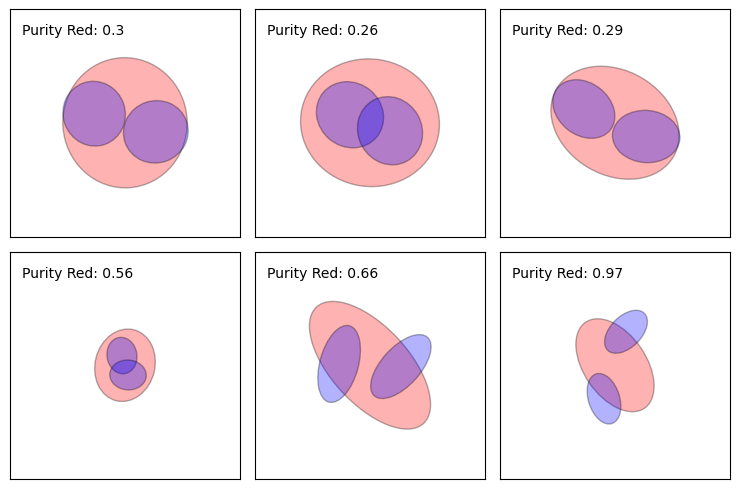

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(7.5,5))

for i, ax in enumerate(axes.ravel()):

    p1_ab, p2_ab, p3_ab = set_unrec_bl()
    
    cov1, cov_inv1 = ab2cov(p1_ab)
    cov2, cov_inv2 = ab2cov(p2_ab)
    cov3, cov_inv3 = ab2cov(p3_ab)
    
    a1, b1, theta1, x1, y1 = p1_ab
    a2, b2, theta2, x2, y2 = p2_ab
    a3, b3, theta3, x3, y3 = p3_ab
    
    int_11 = gaussian_square_int(p1_ab)
    int_12 = gaussian_overlap(p1_ab, p2_ab)
    int_13 = gaussian_overlap(p1_ab, p3_ab)

    purity1 = int_11 / (int_11 + int_12 + int_13)

    ax.text(x=-3.5, y=3.0, s=f'Purity Red: {np.around(purity1, decimals=2)}')

    ellipse1 = Ellipse((x1,y1), width=2*a1, height=2*b1, angle=theta1, facecolor='r', edgecolor='k', alpha=0.3, linewidth=1)
    ellipse2 = Ellipse((x2,y2), width=2*a2, height=2*b2, angle=theta2, facecolor='b', edgecolor='k', alpha=0.3, linewidth=1)
    ellipse3 = Ellipse((x3,y3), width=2*a3, height=2*b3, angle=theta3, facecolor='b', edgecolor='k', alpha=0.3, linewidth=1)
    ax.add_artist(ellipse1)
    ax.add_artist(ellipse2)
    ax.add_artist(ellipse3)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)
    ax.axis('equal')

plt.tight_layout()

## 2. Ellipse Overlap Area
The general ellipse equation from [wikipedia](https://en.wikipedia.org/wiki/Ellipse#General_ellipse), 
but swapping B and C:

$$
A x^2 + B y^2 + C x y +  D x +  E y + F = 0
$$
where 

$$
\begin{align}
A & = a^2\sin^2{\theta} +  b^2\cos^2{\theta},  \\
B & = a^2\cos^2{\theta} +  b^2\sin^2{\theta}, \\
C & = 2(b^2 - a^2)\sin{\theta}\cos{\theta}, \\
D & = -2Ax_0 - Cy_0,  \\
E & = -C x_0 - 2B y_0,  \\
F & = Ax_0^2 + C x_0 y_0 + By_0^2 - a^2 b^2. 
\end{align}
$$

following the definitions of Alberich-Carramiñana+2017 (hereafter [AC2017](https://www.sciencedirect.com/science/article/abs/pii/S0167839617300791)), we shrink the parameters CDE by half,

$$ C = C / 2, \quad D = D / 2, \quad E = E / 2, $$

and modify the Ellipse Equation:

$$
A x^2 + B y^2 + 2C x y + 2 D x + 2 E y + F = 0.
$$

In [7]:
def ellipse_equation_general(p_AB, x, y):
    
    A, B, C, D, E, F = p_AB
    
    return A*x**2 + B*y**2 + 2*C*x*y + 2*D*x + 2*E*y + F

def ab2AB(p_ab):
    
    a, b, theta, x0, y0 = p_ab
    
    ### a, b, in any length units; theta in degrees ###
    sin = np.sin(np.radians(theta))
    cos = np.cos(np.radians(theta))
    
    A = (a*sin)**2 + (b*cos)**2
    B = (a*cos)**2 + (b*sin)**2
    C = 2*(b**2 - a**2)*sin*cos
    D = -2*A*x0 - C*y0
    E = -C*x0 - 2*B*y0
    F = A*x0**2 + C*x0*y0 + B*y0**2 - (a*b)**2
    C, D, E = C/2, D/2, E/2
    
    return [A, B, C, D, E, F]

def AB2ab(p_AB, convention='AC2017'):
    ## converting general parameters (AC2017 convention or wikipedia convention) to ab parameters.

    A, B, C, D, E, F = p_AB
    
    if convention=='AC2017':
        ## AC2017 params to wiki params
        B, C = 2*C, B
        D = 2*D
        E = 2*E
    
    ## wiki AB params to a, b, theta
    Delta = B*B - 4*A*C
    
    f1 = A*E*E + C*D*D - B*D*E + F*Delta
    f2 = np.sqrt( (A-C)**2 + B**2)
    
    a = -np.sqrt(2 * f1 * ( A+C+f2) ) / Delta
    b = -np.sqrt(2 * f1 * ( A+C-f2) ) / Delta
    
    x0 = (2*C*D - B*E) / Delta
    y0 = (2*A*E - B*D) / Delta
    
    if B==0:
        if A < C:
            theta = 0
        else:
            theta = 90
    else:
        theta = np.degrees(np.arctan( (C - A - f2) / B ))
    
    p_ab = [a, b, theta, x0, y0]
    return p_ab


### Solve a quartic equation for interception points

Set up the coordinate system to be aligned with ellipse 1, so that
\begin{equation}
x1=y1=0; \quad \theta_1 = 0,
\end{equation}

And the interception points are found by solving
\begin{equation}
\begin{aligned}
    1 & =\frac{x^2}{a_1^2} + \frac{y^2}{b_1^2} \\
    0 & = A_2 x^2 + B_2 y^2 + 2C_2 x y + 2 D_2 x + 2 E_2 y + F_2.
\end{aligned}
\end{equation}

In [8]:
def quadroot(p1_ab, p2_AB):
    
    ## solve interception in ellipse 1 frame: [x, y, theta] = 0
    a, b, theta, x, y = p1_ab
    A, B, C, D, E, F = p2_AB
    
    e = b/a
    dA = A - B*e**2
    dB = B*b**2 + F
    
    p4 = -4*C**2*e**2 - dA**2
    p3 = -8*C*E*e**2 - 4*dA*D
    p2 = -4*E**2*e**2 + 4*C**2*b**2 - 4*D**2 - 2*dA*dB
    p1 = 8*C*E*b**2 - 4*D*dB
    p0 = 4*E**2*b**2 - dB**2
    
    ## solve for x; accept only real roots
    xroots_prop = np.roots([p4, p3, p2, p1, p0])
    xroots_prop = np.real(xroots_prop[np.isreal(xroots_prop)])

    ## substitute for y
    xroots, yroots = [], []
    
    eps_root = 1e-9
    eps_inter = 1e-3
    
    for x in xroots_prop:
        
        Delta = b**2 - e**2*x**2
        if np.abs(Delta)<eps_root:
            y = 0.0
        else:
            y = np.sqrt(Delta)

        z1 = ellipse_equation_general(p2_AB, x, y)
        z2 = ellipse_equation_general(p2_AB, x, -y)
        
        if (np.abs(z1) <= np.abs(z2)) & (np.abs(z1) < eps_inter):
            xroots.append(x)
            yroots.append(y)
        elif (np.abs(z2) < np.abs(z1)) & (np.abs(z2) < eps_inter):
            xroots.append(x)
            yroots.append(-y)

    ### remove duplicated roots 
    if len(xroots) == 0:
        xroots_unique, yroots_unique = xroots, yroots
        
    else:
        xroots_unique = [xroots[0]]
        yroots_unique = [yroots[0]]

        x_dup = []
        eps_dup = 1e-6

        for x, y in zip(xroots[1:], yroots[1:]):
            dist = (np.array(xroots_unique) - x)**2 + (np.array(yroots_unique) - y)**2
            n_dup = np.sum( (dist<eps_dup) )
            if n_dup == 0:
                xroots_unique.append(x)
                yroots_unique.append(y)
            else:
                x_dup.append(x)
                
    ### if there are 3 roots left:
    ### ( [2 unique roots + 2 double root] -> [2 unique roots + 1 double root] ),
    ### further remove the remaining double root.
    ### (it is a tangential interception which should be ignored).
    
    if len(xroots_unique) == 3:
        for x, y in zip(xroots_unique, yroots_unique):
            if x in x_dup:
                xroots_unique.remove(x)
                yroots_unique.remove(y)
            
    return np.array(xroots_unique), np.array(yroots_unique)
    

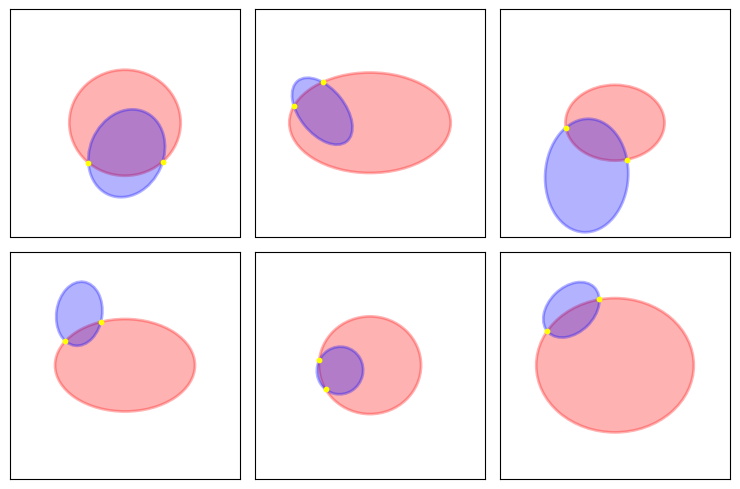

In [9]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(7.5,5))

for i, ax in enumerate(axes.ravel()):

    p1_ab, p2_ab = set_random_pair(center_on_ell1=True)

    a1, b1, theta1, x1, y1 = p1_ab
    a2, b2, theta2, x2, y2 = p2_ab

    p2_AB = ab2AB(p2_ab)

    x_inter, y_inter = quadroot(p1_ab, p2_AB)

    ellipse1 = Ellipse((x1,y1), width=2*a1, height=2*b1, angle=theta1, facecolor='r', edgecolor='r', alpha=0.3, linewidth=2)
    ellipse2 = Ellipse((x2,y2), width=2*a2, height=2*b2, angle=theta2, facecolor='b', edgecolor='b', alpha=0.3, linewidth=2)
    ax.add_artist(ellipse1)
    ax.add_artist(ellipse2)
    
    ax.scatter(x_inter, y_inter, marker="o", s=10, c='yellow', zorder=10) 
    
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)

plt.tight_layout()


### Calculate overlapping area following [Hughes & Chraibi 2011](https://arxiv.org/abs/1106.3787) (**HC2011**).

In [10]:
def map_onto_ell(p_ab, x_global, y_global):
    
    # map a point (x,y) in global coords onto the local coords defined by ellipse:
    # x axis along a, y axis along b, centered on ellipse origin.
    
    a, b, theta, x0, y0 = p_ab
    
    sin = np.sin(np.radians(theta))
    cos = np.cos(np.radians(theta))
    
    x_ell = cos* (x_global-x0) + sin*(y_global-y0)
    y_ell = -sin*(x_global-x0) + cos*(y_global-y0)
    
    return x_ell, y_ell

def map_from_ell(p_ab, x_ell, y_ell):
    
    # map a point (x,y) from the ellipse coordinates back to the global coordinates.
    
    a, b, theta, x0, y0 = p_ab
    
    sin = np.sin(np.radians(theta))
    cos = np.cos(np.radians(theta))
    
    x_global = cos*x_ell - sin*y_ell + x0
    y_global = sin*x_ell + cos*y_ell + y0
    
    return x_global, y_global

def segment_area2(p1_ab, p2_ab, x_inter, y_inter):
    
    a, b, theta, x0, y0 = p1_ab
    p2_AB = ab2AB(p2_ab)
    
    x1_ell, y1_ell = map_onto_ell(p1_ab, x_inter[0], y_inter[0])
    x2_ell, y2_ell = map_onto_ell(p1_ab, x_inter[1], y_inter[1])
    
    t1_ell = np.arctan2(y1_ell*a/b, x1_ell)
    t2_ell = np.arctan2(y2_ell*a/b, x2_ell)
    t_mid = (t1_ell + t2_ell) / 2

    xT_mid_ell, yT_mid_ell = a*np.cos(t_mid), b*np.sin(t_mid)              ## midpoint on This side
    xO_mid_ell, yO_mid_ell = a*np.cos(t_mid+np.pi), b*np.sin(t_mid+np.pi)  ## midpoint on Other side
    
    xT_mid, yT_mid = map_from_ell(p1_ab, xT_mid_ell, yT_mid_ell)               
    xO_mid, yO_mid = map_from_ell(p1_ab, xO_mid_ell, yO_mid_ell)
    
    zT = ellipse_equation_general(p2_AB, xT_mid, yT_mid)
    zO = ellipse_equation_general(p2_AB, xO_mid, yO_mid)
    
    if zT < zO:   ## this side of arc closer to center of ellipse 2
        theta_sector = np.abs(t1_ell - t2_ell)
        x_mid, y_mid = xT_mid, yT_mid
    else:         ## other side closer; flip to other side
        theta_sector = 2*np.pi - np.abs(t1_ell - t2_ell)
        x_mid, y_mid = xO_mid, yO_mid
   
    area_triangle = np.abs( x1_ell*y2_ell - x2_ell*y1_ell ) / 2            
    area_segment = theta_sector * a * b / 2 + np.sign(theta_sector-np.pi)*area_triangle
        
    return area_segment

def segment_area4(p1_ab, p2_ab, x_inter, y_inter):

    a, b, theta, x0, y0 = p1_ab
    p2_AB = ab2AB(p2_ab)
    
    N = len(x_inter)
    
    x_ell, y_ell = map_onto_ell(p1_ab, x_inter, y_inter)
    t_ell = np.arctan2(y_ell*a/b, x_ell)

    x_ell = [x for t, x in sorted(zip(t_ell, x_ell))]
    y_ell = [y for t, y in sorted(zip(t_ell, y_ell))]
    t_ell = sorted(t_ell)
    
    x_mid, y_mid, z_mid = np.empty(N), np.empty(N), np.empty(N)
    t_mid, t_diff = np.empty(N), np.empty(N)
    area_triangle = np.empty(N)
   
    for i in range(N):
        j = (i+1)%N     ## periodic boundary N->0
        t_mid[i] = (t_ell[i] + t_ell[j])/2
        t_diff[i] = np.abs(t_ell[i] - t_ell[j])
        
        ## the last two points jump from +pi to -pi due to arctan2; fixing it
        if j == 0:
            t_mid[i] += np.pi
            t_diff[-1] = 2*np.pi - t_diff[-1]

        x_mid[i], y_mid[i] = map_from_ell(p1_ab, a*np.cos(t_mid[i]), b*np.sin(t_mid[i]))
        z_mid[i] = ellipse_equation_general(p2_AB, x_mid[i], y_mid[i])
        area_triangle[i] = np.abs( x_ell[i]*y_ell[j] - x_ell[j]*y_ell[i] ) / 2 

    t_sign = np.sign( t_diff - np.pi )
    
    if (z_mid[0] < 0) & (z_mid[2] < 0):

        area_segment_01 = t_diff[0] * a * b / 2 + t_sign[0]*area_triangle[0]
        area_segment_23 = t_diff[2] * a * b / 2 + t_sign[2]*area_triangle[2]
        
        area_segments = area_segment_01 + area_segment_23
        return area_segments, x_ell, y_ell
    
    elif (z_mid[1] < 0) & (z_mid[3] < 0):
        
        area_segment_12 = t_diff[1] * a * b / 2 + t_sign[1]*area_triangle[1]
        area_segment_30 = t_diff[3] * a * b / 2 + t_sign[3]*area_triangle[3]
        
        area_segments = area_segment_12 + area_segment_30
        return area_segments, x_ell, y_ell


def overlap_area_HC(p1_ab, p2_ab, x_inter=[], y_inter=[]):
    
    a1, b1, theta1, x1, y1 = p1_ab
    a2, b2, theta2, x2, y2 = p2_ab
    
    area = -1

    num_inter = len(x_inter)
    match num_inter:
        
        case 0:  ## 0 interception points
            
            p1_AB = ab2AB(p1_ab)
            p2_AB = ab2AB(p2_ab)
            
            z1 = ellipse_equation_general(p1_AB, x2, y2)
            z2 = ellipse_equation_general(p2_AB, x1, y1)
            
            if (z1<0) | (z2<0):  ## one inside another
                area = min(np.pi*a1*b1, np.pi*a2*b2)
            else:                ## separated
                area = 0.0
                
        case 1:  ## 1 interception points; same procedure as 0
            
            p1_AB = ab2AB(p1_ab)
            p2_AB = ab2AB(p2_ab)
            
            z1 = ellipse_equation_general(p1_AB, x2, y2)
            z2 = ellipse_equation_general(p2_AB, x1, y1)
            
            if (z1<0) | (z2<0):  ## one inside another
                area = min(np.pi*a1*b1, np.pi*a2*b2)
            else:                ## separated
                area = 0.0
            
        case 2: ## 2 interception points
            
            A1 = segment_area2(p1_ab, p2_ab, x_inter, y_inter)
            A2 = segment_area2(p2_ab, p1_ab, x_inter, y_inter)

            area = A1 + A2
            
        case 4: ## 4 interception points

            A1, x_ell, y_ell = segment_area4(p1_ab, p2_ab, x_inter, y_inter)
            A2, _____, _____ = segment_area4(p2_ab, p1_ab, x_inter, y_inter)

            A_quad = np.abs( (x_ell[0] - x_ell[2]) * (y_ell[1] - y_ell[3]) \
                            - (x_ell[1] - x_ell[3]) * (y_ell[0] - y_ell[2]) ) /2

            area = A1 + A2 + A_quad

    return area
    

## 3. Ellipse Overlap Area - Monte Carlo Sampling
Such an easy yet powerful approach.

In [11]:
def overlap_area_MC(p1_AB, p2_AB, xlim=[0,1], ylim=[0,1], Nx=100, Ny=100):
    
    N_total = Nx * Ny
    A_total = (xlim[1] - xlim[0]) * (ylim[1] - ylim[0])
    
    x_grid, y_grid = np.meshgrid( np.linspace(xlim[0], xlim[1], Nx), np.linspace(ylim[0], ylim[1], Ny) )
    Z1 = ellipse_equation_general( p1_AB, x_grid, y_grid )
    Z2 = ellipse_equation_general( p2_AB, x_grid, y_grid )
    
    N_inside = np.sum( (Z1<0) & (Z2<0) )
    
    return A_total * N_inside / N_total

## Joint example of method 2 and 3

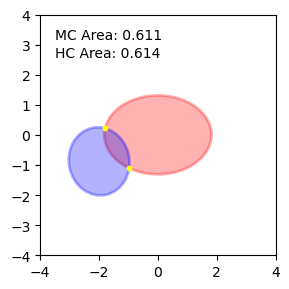

In [12]:
xlim=[-4,4]
ylim=[-4,4]
N_MC=500

p1_ab, p2_ab = set_random_pair(center_on_ell1=True)

a1, b1, theta1, x1, y1 = p1_ab
a2, b2, theta2, x2, y2 = p2_ab

p1_AB = ab2AB(p1_ab)
p2_AB = ab2AB(p2_ab)

x_inter, y_inter = quadroot(p1_ab, p2_AB)

fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111, xlim=xlim, ylim=ylim)

ellipse1 = Ellipse((x1,y1), width=2*a1, height=2*b1, angle=theta1, facecolor='r', edgecolor='r', alpha=0.3, linewidth=2)
ellipse2 = Ellipse((x2,y2), width=2*a2, height=2*b2, angle=theta2, facecolor='b', edgecolor='b', alpha=0.3, linewidth=2)
ax.add_artist(ellipse1)
ax.add_artist(ellipse2)
ax.scatter(x_inter, y_inter, marker="o", s=10, c='yellow', zorder=10) 

A_overlap_MC = overlap_area_MC(p1_AB, p2_AB, xlim=xlim, ylim=ylim, Nx=N_MC, Ny=N_MC)
A_overlap_HC = overlap_area_HC(p1_ab, p2_ab, x_inter=x_inter, y_inter=y_inter)

ax.text(x=-3.5, y=3.2, s=f'MC Area: {np.around(A_overlap_MC, decimals=3)}')
ax.text(x=-3.5, y=2.6, s=f'HC Area: {np.around(A_overlap_HC, decimals=3)}')

plt.tight_layout()

## Efficiency test

In [13]:
def set_random_pairs(N=1000, center_on_ell1=False):
    
    if center_on_ell1:
        X1, Y1 = 0, 0
        T1 = 0
    else:
        X1, Y1 = np.random.uniform(-2,2,size=N)  ## center of ellipse 1
        T1 = np.random.uniform(0, 180, size=N)   ## in degrees
        
    A1 = np.random.uniform(1,3,size=N)
    B1 = np.random.uniform(1,3,size=N)

    X2 = np.random.uniform(-3,3,size=N)
    Y2 = np.random.uniform(-3,3,size=N)
    A2 = np.random.uniform(1,3,size=N)
    B2 = np.random.uniform(1,3,size=N)
    T2 = np.random.uniform(0, 180, size=N)

    P1_ab, P2_ab = np.empty((N,5)), np.empty((N,5))
    P1_AB, P2_AB = np.empty((N,6)), np.empty((N,6))

    for i in range(N):

        if A1[i] > B1[i]:
            p1_ab = [A1[i], B1[i], theta1, x1, y1]
        else:
            p1_ab = [B1[i], A1[i], theta1, x1, y1]

        if A2[i] > B2[i]:
            p2_ab = [A2[i], B2[i], T2[i], X2[i], Y2[i]]
        else:
            p2_ab = [B2[i], A2[i], T2[i], X2[i], Y2[i]]

        P1_ab[i,:] = p1_ab
        P2_ab[i,:] = p2_ab
        P1_AB[i,:] = ab2AB(p1_ab)
        P2_AB[i,:] = ab2AB(p2_ab)
        
    return P1_ab, P2_ab, P1_AB, P2_AB

In [14]:
N = 10000
Area_HC = np.empty(N)
Area_MC = np.empty(N)
Area_GP = np.empty(N)
Purity = np.empty(N)

P1_ab, P2_ab, P1_AB, P2_AB = set_random_pairs(N=N, center_on_ell1=True)

In [15]:
N_MC=100

start_time = timeit.default_timer()

for i in range(N):
    
    Area_MC[i] = overlap_area_MC(P1_AB[i,:], P2_AB[i,:], \
                                                    xlim=[-P1_ab[i][0], P1_ab[i][0]], \
                                                    ylim=[-P1_ab[i][1], P1_ab[i][1]], \
                                                    Nx=N_MC, Ny=N_MC)

elapsed = timeit.default_timer() - start_time
print(elapsed)

1.6797541140113026


In [16]:
start_time = timeit.default_timer()

for i in range(N):

    x_inter, y_inter = quadroot(P1_ab[i,:], P2_AB[i,:])
    Area_HC[i] = overlap_area_HC(P1_ab[i,:], P2_ab[i,:], x_inter=x_inter, y_inter=y_inter)

elapsed = timeit.default_timer() - start_time
print(elapsed)

1.765447546960786


In [17]:
start_time = timeit.default_timer()

for i in range(N):
    
    Area_GP[i] = gaussian_overlap(P1_ab[i], P2_ab[i])
    Purity[i] = Area_GP[i] / (gaussian_square_int(P1_ab[i]) + Area_GP[i])

elapsed = timeit.default_timer() - start_time
print(elapsed)

0.6670126388780773


## Consistency Test

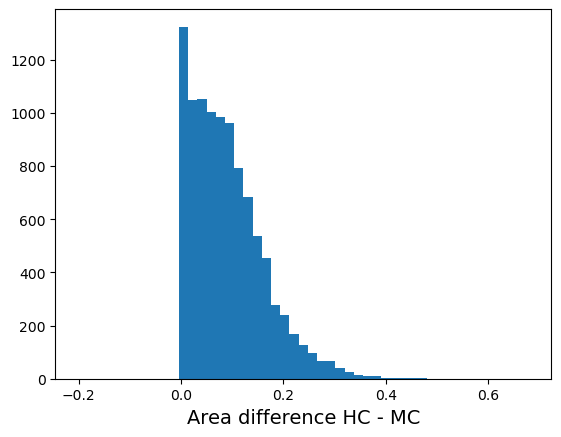

In [18]:
diff = Area_HC - Area_MC
plt.hist(diff, bins=np.linspace(diff.min()-0.2, diff.max()+0.2,50));
plt.xlabel('Area difference HC - MC', size=14);

In [19]:
Frac = Area_HC / (np.pi*P1_ab[:,0]*P1_ab[:,1])  ## overlap fraction of ellipse 1

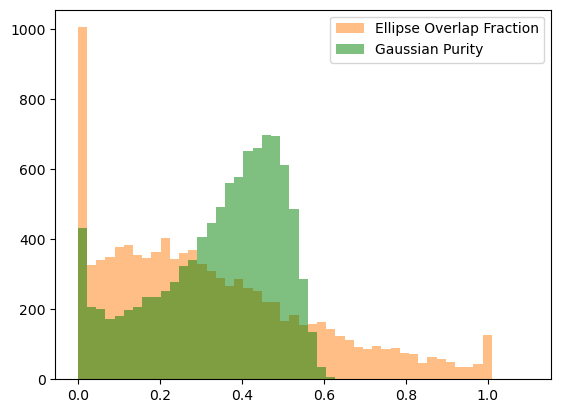

In [20]:
bins = np.linspace(0, 1.1, 50)
plt.hist(Frac, alpha=0.5, color='C1', bins=bins, label='Ellipse Overlap Fraction');
plt.hist(Purity, alpha=0.5, color='g', bins=bins, label='Gaussian Purity');
plt.legend();

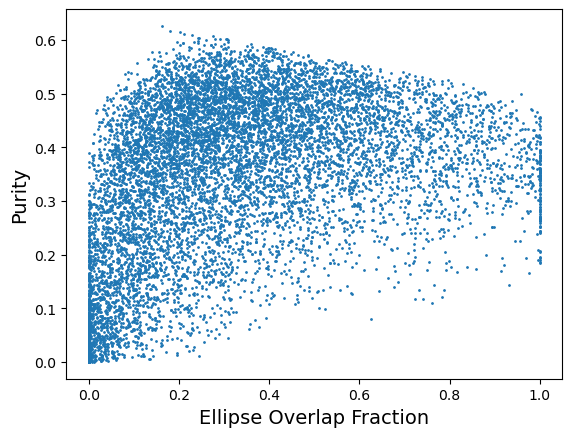

In [21]:
plt.scatter(Frac, Purity, s=1);
plt.xlabel('Ellipse Overlap Fraction', fontsize=14);
plt.ylabel('Purity', fontsize=14);

### (Deprecated):  An algorithm to detect relative position types of two ellipses, described in Alberich-Carramiñana+2017 ([AC2017](https://www.sciencedirect.com/science/article/abs/pii/S0167839617300791)).

In [22]:
def polyQ(x, m0, m1, m2):
    return m2*x**2 + 2*m1*x + m0

def polyR(x, r0, r1, r2):
    return r2*x**2 + 2*r1*x + r0
    
def get_inter_type(p1, p2, convention='Binary'):
    
    A1, B1, C1, D1, E1, F1 = p1
    A2, B2, C2, D2, E2, F2 = p2
    
    M1 = [[A1, C1, D1], [C1, B1, E1], [D1, E1, F1]]
    M2 = [[A2, C2, D2], [C2, B2, E2], [D2, E2, F2]]
    
    l0 = np.linalg.det(M2)
    l1 = (np.linalg.det([[A1,C2,D2],[C1,B2,E2],[D1,E2,F2]]) +
            np.linalg.det([[A2,C1,D2],[C2,B1,E2],[D2,E1,F2]]) +
            np.linalg.det([[A2,C2,D1],[C2,B2,E1],[D2,E2,F1]])) / 3
    l2 = (np.linalg.det([[A2,C1,D1],[C2,B1,E1],[D2,E1,F1]]) +
            np.linalg.det([[A1,C2,D1],[C1,B2,E1],[D1,E2,F1]]) +
            np.linalg.det([[A1,C1,D2],[C1,B1,E2],[D1,E1,F2]])) / 3
    l3 = np.linalg.det(M1)

    delta1 = np.linalg.det([[l3, l2],[l2, l1]])
    delta2 = np.linalg.det([[l3, l1],[l2, l0]])
    delta3 = np.linalg.det([[l2, l1],[l1, l0]])
    Delta_P = np.linalg.det([[2*delta1, delta2], [delta2, 2*delta3]])
    
    eps = 1e-3
    if convention == 'Binary':
        if (Delta_P >=-eps) and ((l1>0) or (l2>0)):
            return 3  ## not over-lapping
        else:
            return 4
    
    elif convention =='AC2017':
        lambdaT = - l2/l3
        lambdaD = - delta2/(2*delta1)
        lambdaS = - (l0*delta2)/(l3*delta3)

        m2 = np.linalg.det( [[A1, C1], [C1, B1]] )
        m1 = np.linalg.det( [[A2, C1], [C2, B1]] )/2 + np.linalg.det( [[A1, C2], [C1, B2]] )/2
        m0 = np.linalg.det( [[A2, C2], [C2, B2]] )

        Delta_Q = 4 * np.linalg.det([ [m1, m0], [m2, m1]] )

        r2 = np.linalg.det( [[A1, D1], [D1, F1]] ) + np.linalg.det( [[B1, E1], [E1, F1]] )
        r1 = ( np.linalg.det( [[A2, D1], [D2, F1]] ) + np.linalg.det( [[A1, D2], [D1, F2]] ) \
              +np.linalg.det( [[B2, E1], [E2, F1]] ) + np.linalg.det( [[B1, E2], [E1, F2]] ) ) / 2
        r0 = np.linalg.det([ [A2, D2], [D2, F2]] ) + np.linalg.det( [[B2, E2], [E2, F2]] )

        s2 = np.linalg.det([[l2, l3], [m1, m2]])
        s1 = np.linalg.det([[l1, l3], [m0, m2]])
        s0 = np.linalg.det([[l1, l2], [m0, m1]])

        Delta_W = np.linalg.det( [[s1, 2*s2], [2*s0, s1]] )

        Q_Lt = polyQ(lambdaT, m0, m1, m2)
        Q_Ld = polyQ(lambdaD, m0, m1, m2)
        Q_Ls = polyQ(lambdaS, m0, m1, m2)

        R_Lt = polyR(lambdaT, r0, r1, r2)
        R_Ld = polyR(lambdaD, r0, r1, r2)

        inter_type = -1
        eps = 1e-3
        if (Delta_P < -eps):
            inter_type = 2

        elif ((l1>0) or (l2>0)):
            if (Delta_P > eps):
                inter_type = 3
            else:
                inter_type = 7

        elif (Delta_P > eps):
            if ( (Q_Lt < 0) and (Delta_W > 0) ):
                inter_type = 1
            else:
                inter_type = 4
        elif ( (np.abs(delta2) < eps) and (np.abs(delta3) < eps) ):
            if ( (np.abs(Q_Lt) < eps) and (np.abs(R_Lt) < eps) ):
                if ( np.abs(Delta_Q) < eps ):
                    inter_type = 0
                else:
                    inter_type = 11
            else:
                inter_type = 10
        elif ( (np.abs(Q_Ld) < eps) and (np.abs(R_Ld) < eps) ):
            if (Q_Ls < eps):
                inter_type = 9
            else:
                inter_type = 5
        elif (Q_Ld < eps):
            inter_type = 6
        else:
            inter_type = 8

        return inter_type

### set up some examples

In [23]:
def set_inter_type(config=-1):
    
    match config:
        
        case 0: ## identical ellipses    
            p1_ab = [3, 2, 0, 0, 0]
            p2_ab = p1_ab

        case 1:  ## 4 intersections
            p1_ab = [3, 2, 0, 0, 0]
            p2_ab = [3, 1, 45, 1, -0.5]

        case 2:  ## 2 intersections
            p1_ab = [3, 2, 0, 0, 0]
            p2_ab = [2, 1, 45, -2, -1]

        case 3:  ## separated
            p1_ab = [2, 1, 0, 0, 0]
            p2_ab = [1.5, 0.75, 45, -2.5, -2.0]

        case 4:  ## contained
            p1_ab = [3, 2, 0, 0, 0]
            p2_ab = [2, 1, 45, -0.75, 0.25]

        case 5:  ## projectively concentric circles          
            p1_AB = [1/4, 1/4, 0, 0, 0, -1]
            p2_AB = [1/5, 1/5, 0, 0, 0, -1]
            
            p1_ab = AB2ab(p1_AB)
            p2_ab = AB2ab(p2_AB)

        case 6:  ## 1 tangent, 2 intersections
            p1_ab = [3, 2, 0, 0, 0]
            p2_ab = [3, 3, 0, 0, 1]

        case 7:  ## externally tangent
            p1_ab = [2, 1, 0, 0, -1]
            p2_ab = [2, 1, 0, 0, 1]

        case 8:  ## internally tangent at 1 point
            p1_ab = [3, 2, 0, 0, 0]
            p2_ab = [2, 1, 45, -1.0245209260022, 0.25]

        case 9:  ## internally tangent at 2 points
            p1_ab = [3, 2, 0, 0, 0]
            p2_ab = [1, 2, 0, 0, 0]

        case 10: ## osculating; tangency of 2nd order
            ## http://www.grad.hr/geomteh3d/skripta/zakrivljenost_eng.html
            p1_AB = [1, 1, 0, 0, 0, -1]
            p2_AB = [5, 5, 3, 0, 3, -5]
            
            p1_ab = AB2ab(p1_AB)
            p2_ab = AB2ab(p2_AB)
          
        case 11: ## hyper-osculating; tangency of 3rd order
            ## https://www.geogebra.org/m/chz6rrb9
            p1_ab = [3, 2, 0, 0, 0]
            p2_ab = [4.0/3.0, 4.0/3.0, 0, 4.0/3.0 - 3, 0]

        case -1:  ## random 
            x1, y1 = 0, 0
            a1, b1 = np.random.uniform(1,3,2)
            theta1 = 0
            if b1 > a1:
                a1, b1 = b1, a1

            x2, y2 = np.random.uniform(-2,2,2)  ## center of ellipse 2
            y2 -= 0.5
            a2, b2 = np.random.uniform(0.5,2,2)
            theta2 = np.random.uniform(0, 180)  ## in degrees
            if b2 > a2:
                a2, b2 = b2, a2
                
            p1_ab = [a1, b1, theta1, x1, y1]
            p2_ab = [a2, b2, theta2, x2, y2]

    return p1_ab, p2_ab


/tmp/ipykernel_230279/1330830580.py:38: RuntimeWarning: invalid value encountered in double_scalars
  lambdaD = - delta2/(2*delta1)
/tmp/ipykernel_230279/1330830580.py:39: RuntimeWarning: invalid value encountered in double_scalars
  lambdaS = - (l0*delta2)/(l3*delta3)
/tmp/ipykernel_230279/1330830580.py:38: RuntimeWarning: divide by zero encountered in double_scalars
  lambdaD = - delta2/(2*delta1)
/tmp/ipykernel_230279/1330830580.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  lambdaS = - (l0*delta2)/(l3*delta3)


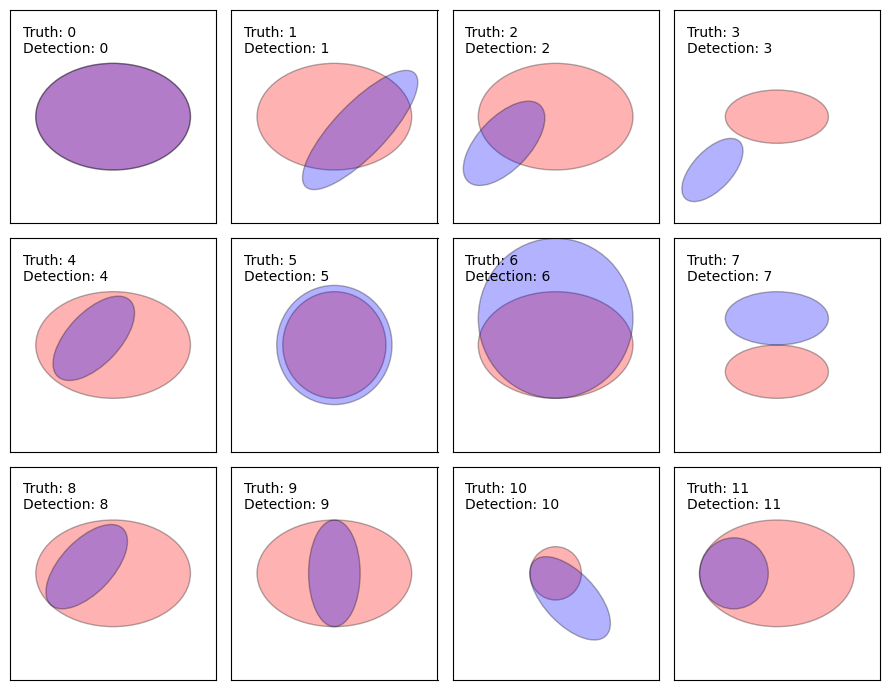

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(9,7))

for i, ax in enumerate(axes.ravel()):

    p1_ab, p2_ab = set_inter_type(config=i)

    a1, b1, theta1, x1, y1 = p1_ab
    a2, b2, theta2, x2, y2 = p2_ab

    p1_AB = ab2AB(p1_ab)
    p2_AB = ab2AB(p2_ab)

    inter_type = get_inter_type(p1_AB, p2_AB, convention='AC2017')
    ax.text(x=-3.5, y=3.0, s=f'Truth: {i}')
    ax.text(x=-3.5, y=2.4, s=f'Detection: {inter_type}')

    ellipse1 = Ellipse((x1,y1), width=2*a1, height=2*b1, angle=theta1, facecolor='r', edgecolor='k', alpha=0.3, linewidth=1)
    ellipse2 = Ellipse((x2,y2), width=2*a2, height=2*b2, angle=theta2, facecolor='b', edgecolor='k', alpha=0.3, linewidth=1)
    ax.add_artist(ellipse1)
    ax.add_artist(ellipse2)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xlim(-4,4)
    ax.set_ylim(-4,4)

plt.tight_layout()